<font size="+0.5">Load libraries and data.</font>

In [1]:
# Ignore warnings 
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight

In [3]:
data_acc = pd.read_csv('data/filtering_accelerometer.csv')
data_gyr = pd.read_csv('data/filtering_gyroscope.csv')
data = pd.concat([data_acc, data_gyr.drop(["event"], axis=1)], axis=1)

# <center> Data preprocessing

<font size="+0.5">Label encoding.</font>

<font size="+0.5">Divide data into 3 categories then encode them.</font>

In [4]:
label_dict = {"Aggressive acceleration": "critical",
         "Aggressive breaking": "critical", 
         "Aggressive left lane change": "significant",
         "Aggressive left turn": "significant",
         "Aggressive right lane change": "significant",
         "Aggressive right turn": "significant",
         "Non-aggressive event": "negligible"}

In [5]:
def change_label(row):
    return label_dict[row['event']]

In [6]:
data['event_label'] = data.apply(change_label, axis=1)

In [7]:
data.head()

,x_accelerometer,x_accelerometer_fil,y_accelerometer,y_accelerometer_fil,z_accelerometer,z_accelerometer_fil,event,x_gyroscope,x_gyroscope_fil,y_gyroscope,y_gyroscope_fil,z_gyroscope,z_gyroscope_fil,event_label
0,0.039886,0.112064,0.085735,0.099807,-0.093183,-0.115853,Non-aggressive event,0.004470,-0.004287,0.009398,0.007023,-0.002575,0.000821,negligible
1,0.141136,0.078692,0.180840,0.141873,-0.101005,-0.118248,Non-aggressive event,-0.018279,-0.004187,0.007015,0.005186,0.007037,0.003043,negligible
2,0.048727,0.054416,0.133385,0.169328,-0.183827,-0.120858,Non-aggressive event,0.001196,-0.003719,-0.000405,0.003630,0.001179,0.004593,negligible
3,0.095980,0.037768,0.250396,0.185177,-0.111719,-0.123490,Non-aggressive event,-0.004479,-0.003007,0.000623,0.002345,0.013621,0.005579,negligible
4,0.021541,0.027424,0.098266,0.192126,-0.187710,-0.125977,Non-aggressive event,0.006300,-0.002162,-0.011864,0.001319,0.003479,0.006099,negligible


In [8]:
encoder = LabelEncoder()
data['event_label_num'] = encoder.fit_transform(data['event_label'])

In [9]:
with open("models/encoder.pcl", "wb") as file:
    pickle.dump(encoder, file)

<font size="+0.5">Look at histogramm of the target class.</font>

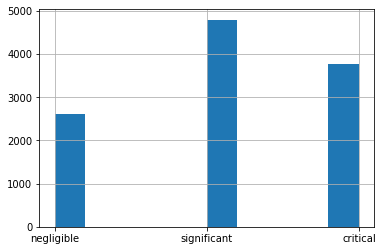

In [10]:
data['event_label'].hist();

<font size="+0.5">Data normalisation.</font>

<font size="+0.5">Linear models have to work with normilized data.</font>

In [11]:
normalizer = StandardScaler()

data['x_accelerometer_fil_scaled'] = normalizer.fit_transform(data['x_accelerometer_fil'].values.reshape(-1, 1))
with open("models/x_scaler.pcl", "wb") as file:
    pickle.dump(normalizer, file)
data['y_accelerometer_fil_scaled'] = normalizer.fit_transform(data['y_accelerometer_fil'].values.reshape(-1, 1))
with open("models/y_scaler.pcl", "wb") as file:
    pickle.dump(normalizer, file)
data['z_accelerometer_fil_scaled'] = normalizer.fit_transform(data['z_accelerometer_fil'].values.reshape(-1, 1))
with open("models/z_scaler.pcl", "wb") as file:
    pickle.dump(normalizer, file)

In [12]:
normalizer = MinMaxScaler()
data['x_gyroscope_fil_scaled'] = normalizer.fit_transform(data['x_gyroscope_fil'].values.reshape(-1, 1))
data['y_gyroscope_fil_scaled'] = normalizer.fit_transform(data['y_gyroscope_fil'].values.reshape(-1, 1))
data['z_gyroscope_fil_scaled'] = normalizer.fit_transform(data['z_gyroscope_fil'].values.reshape(-1, 1))

<font size="+0.5">Plots for showing difference in the initial, filtered  and normilized values.</font>

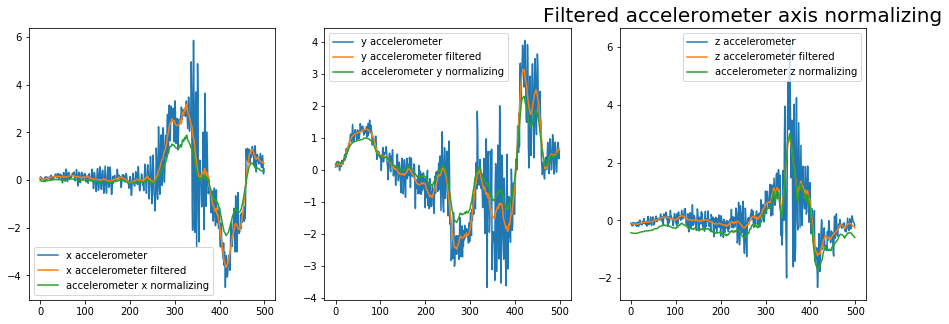

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
ax[0].plot(data[:500]['x_accelerometer'].values, label='x accelerometer')
ax[0].plot(data[:500]['x_accelerometer_fil'].values, label='x accelerometer filtered')
ax[0].plot(data[:500]['x_accelerometer_fil_scaled'].values, label='accelerometer x normalizing')
ax[0].legend();

ax[1].plot(data[:500]['y_accelerometer'].values, label='y accelerometer')
ax[1].plot(data[:500]['y_accelerometer_fil'].values, label='y accelerometer filtered')
ax[1].plot(data[:500]['y_accelerometer_fil_scaled'].values, label='accelerometer y normalizing')
ax[1].legend();

ax[2].plot(data[:500]['z_accelerometer'].values, label='z accelerometer')
ax[2].plot(data[:500]['z_accelerometer_fil'].values, label='z accelerometer filtered')
ax[2].plot(data[:500]['z_accelerometer_fil_scaled'].values, label='accelerometer z normalizing')
ax[2].legend();

plt.title('Filtered accelerometer axis normalizing', fontsize=20)
plt.show();

# <center> Feature engineering

<font size="+0.5">Add acceleration feature</font>

In [14]:
data['acceleration'] = np.sqrt(data['x_accelerometer']**2 + data['y_accelerometer']**2 + data['z_accelerometer']**2)
data['acceleration_fil'] = np.sqrt(data['x_accelerometer_fil']**2 + data['y_accelerometer_fil']**2 + data['z_accelerometer_fil']**2)
data['acceleration_fil_scaled'] = np.sqrt(data['x_accelerometer_fil_scaled']**2 + data['y_accelerometer_fil_scaled']**2 + data['z_accelerometer_fil_scaled']**2)

# <center> Training and evaluating

### <center> Linear models

<font size="+0.5">Split data into train and test</font>

In [15]:
x = data[['x_accelerometer_fil_scaled', 'y_accelerometer_fil_scaled', 'z_accelerometer_fil_scaled', 'acceleration_fil_scaled', "x_gyroscope_fil_scaled", "y_gyroscope_fil_scaled", "z_gyroscope_fil_scaled"]]
y = data['event_label_num']

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state = 42, shuffle = True)

<font size="+0.5">On the histogramm of the target class we see that it isn't balanced. We can't use cutting or dublicating for balancing data, so we dicided to use class weight.</font>

In [16]:
class_weight = dict(zip(np.unique(y), compute_class_weight('balanced', np.unique(y), y)))

In [17]:
clf_lr = LogisticRegression(class_weight=class_weight, random_state = 42)
clf_lr.fit(x_train, y_train)
lr_predict_val = clf_lr.predict(x_val)
lr_predict_train = clf_lr.predict(x_train)
print(f"Train accuracy: {accuracy_score(lr_predict_train, y_train)}")
print(f"Validation accuracy: {accuracy_score(lr_predict_val, y_val)}")

Train accuracy: 0.609094982078853
Validation accuracy: 0.6171070309001343


In [18]:
clf_pac = PassiveAggressiveClassifier(class_weight=class_weight, random_state=42)
clf_pac.fit(x_train, y_train)
pac_predict_val = clf_pac.predict(x_val)
pac_predict_train = clf_pac.predict(x_train)
print(f"Train accuracy: {accuracy_score(pac_predict_train, y_train)}")
print(f"Validation accuracy: {accuracy_score(pac_predict_val, y_val)}")

Train accuracy: 0.5632840501792115
Validation accuracy: 0.5660546350201523


In [19]:
clf_svc = SVC(class_weight=class_weight, random_state=42)
clf_svc.fit(x_train, y_train)
svc_predict_val = clf_svc.predict(x_val)
svc_predict_train = clf_svc.predict(x_train)
print(f"Train accuracy: {accuracy_score(svc_predict_train, y_train)}")
print(f"Validation accuracy: {accuracy_score(svc_predict_val, y_val)}")

Train accuracy: 0.775649641577061
Validation accuracy: 0.7774294670846394


In [20]:
clf_pcp = MLPClassifier(random_state=42, solver='lbfgs', max_iter=1000, hidden_layer_sizes=50)
clf_pcp.fit(x_train, y_train)
pcp_predict_val = clf_pcp.predict(x_val)
pcp_predict_train = clf_pcp.predict(x_train)
print(f"Train accuracy: {accuracy_score(pcp_predict_train, y_train)}")
print(f"Validation accuracy: {accuracy_score(pcp_predict_val, y_val)}")

Train accuracy: 0.926747311827957
Validation accuracy: 0.9135691894312584


<font size="+0.5">Use GridSearch for find better parameters for best linear models.</font>

In [21]:
param_svc = {
    "C": np.arange(18, 21, 1),
    'gamma': np.arange(12, 17, 1)
            }
clf_grid = GridSearchCV(SVC(class_weight=class_weight, random_state=42), param_svc, scoring=make_scorer(accuracy_score), verbose=1, n_jobs=-1)
clf_grid.fit(x_train, y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   24.4s finished


In [22]:
best_svc_estimator = clf_grid.best_estimator_
grid_predict_val = best_svc_estimator.predict(x_val)
grid_predict_train = best_svc_estimator.predict(x_train)
print(f"Train accuracy: {accuracy_score(grid_predict_train, y_train)}")
print(f"Validation accuracy: {accuracy_score(grid_predict_val, y_val)}")

Train accuracy: 0.9823028673835126
Validation accuracy: 0.9444693237796686


In [23]:
param_mlp = {
    "hidden_layer_sizes": np.arange(50, 200, 50),
    "activation": ["logistic", "relu"],
    "solver": ["adam", "lbfgs"],
    "alpha": [1e-4, 1e-3, 1e-2]}
clf_grid = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), param_mlp, scoring=make_scorer(accuracy_score), verbose=1, n_jobs=-1)
clf_grid.fit(x_train, y_train);

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  9.4min finished


In [24]:
best_mlp_estimator = clf_grid.best_estimator_
grid_predict_val = best_mlp_estimator.predict(x_val)
grid_predict_train = best_mlp_estimator.predict(x_train)
print(f"Train accuracy: {accuracy_score(grid_predict_train, y_train)}")
print(f"Validation accuracy: {accuracy_score(grid_predict_val, y_val)}")

Train accuracy: 0.9498207885304659
Validation accuracy: 0.9328257948947604


### <center> Non-linear models

<font size="+0.5">Split data into train and test</font>

In [25]:
x = data[['x_accelerometer_fil', 'y_accelerometer_fil', 'z_accelerometer_fil', 'acceleration_fil', "x_gyroscope_fil", "y_gyroscope_fil", "z_gyroscope_fil"]]
y = data['event_label_num']
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state = 42, shuffle = True)

In [26]:
clf_gbc = GradientBoostingClassifier()
clf_gbc.fit(x_train, y_train)
gbc_predict_val = clf_gbc.predict(x_val)
gbc_predict_train = clf_gbc.predict(x_train)
print(f"Train accuracy: {accuracy_score(gbc_predict_train, y_train)}")
print(f"Validation accuracy: {accuracy_score(gbc_predict_val, y_val)}")

Train accuracy: 0.9155465949820788
Validation accuracy: 0.8871473354231975


In [27]:
clf_rfc = RandomForestClassifier(n_estimators=100, class_weight=class_weight, random_state=42)
clf_rfc.fit(x_train, y_train)
rfc_predict_val = clf_rfc.predict(x_val)
rfc_predict_train = clf_rfc.predict(x_train)
print(f"Train accuracy: {accuracy_score(rfc_predict_train, y_train)}")
print(f"Validation accuracy: {accuracy_score(rfc_predict_val, y_val)}")

Train accuracy: 1.0
Validation accuracy: 0.9695476936856248


In [28]:
clf_dtc = DecisionTreeClassifier(random_state=42, class_weight=class_weight)
clf_dtc.fit(x_train, y_train)
dtc_predict_val = clf_dtc.predict(x_val)
dtc_predict_train = clf_dtc.predict(x_train)
print(f"Train accuracy: {accuracy_score(dtc_predict_train, y_train)}")
print(f"Validation accuracy: {accuracy_score(dtc_predict_val, y_val)}")

Train accuracy: 1.0
Validation accuracy: 0.9202866099417824


<font size="+0.5">Use GridSearch for find better parameters for best non-linear model.</font>

In [29]:
param_forest = {"n_estimators": np.arange(180, 220, 10),
                "max_depth": np.arange(36, 46, 2)}
clf_grid = GridSearchCV(RandomForestClassifier(n_jobs=-1, class_weight=class_weight, random_state=42), param_forest, scoring=make_scorer(accuracy_score), verbose=1, n_jobs=-1)
clf_grid.fit(x_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.4s finished


In [30]:
best_forest_estimator = clf_grid.best_estimator_
grid_predict_val = best_forest_estimator.predict(x_val)
grid_predict_train = best_forest_estimator.predict(x_train)
print(f"Train accuracy: {accuracy_score(grid_predict_train, y_train)}")
print(f"Validation accuracy: {accuracy_score(grid_predict_val, y_val)}")

Train accuracy: 1.0
Validation accuracy: 0.9699955217196596


<font size="+0.5">In the end we dicided to check work of the boosting for this task.</font>

In [31]:
clf_lgb = lgb.LGBMClassifier(
    n_estimators = 800,
    seed = 42,
    learning_rate = 0.015,
    metric = 'multi_logloss',
    objective = 'multiclass',
    early_stopping = 20)

In [32]:
clf_lgb.fit(X=x_train, y=y_train, eval_set=(x_val, y_val), verbose=0)
lgb_predict_val = clf_lgb.predict(x_val)
lgb_predict_train = clf_lgb.predict(x_train)
print(f"Train accuracy: {accuracy_score(lgb_predict_train, y_train)}")
print(f"Validation accuracy: {accuracy_score(lgb_predict_val, y_val)}")

/home/slelelko/PycharmProjects/car-driving-anomalies/venv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train accuracy: 0.9959677419354839
Validation accuracy: 0.961486789072996


In [33]:
with open("models/random_forest.pcl", "wb") as file:
    pickle.dump(best_forest_estimator, file)

In [34]:
with open("models/svc.pcl", "wb") as file:
    pickle.dump(best_svc_estimator, file)